# Example 2:  M/M/1 Queue with N-Policy – Modeling a Video Player
---
> (c) Tobias Hossfeld (April 2025)
>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):
Tran-Gia, P. & Hossfeld, T. (2021). Performance Modeling and Analysis of Communication Networks - A Lecture Note. Würzburg University Press. https://doi.org/10.25972/WUP-978-3-95826-153-2
---

In this example, we model an **M/M/1 queue with N-Policy**, which is particularly useful for representing systems like **video streaming buffers**. The **N-Policy** introduces a threshold: the server (e.g., the video decoder) remains **idle** until the number of jobs (e.g., buffered video frames) reaches a predefined value **N**. Once the buffer has at least N frames, playback begins and continues as long as there are jobs in the system.

This mechanism prevents frequent start/stop behavior (known as jitter or stalling) by ensuring that playback only starts when the buffer is sufficiently full - much like how streaming services pre-buffer several seconds before playing a video. It reflects a key trade-off in video playback: balancing startup delay versus playback smoothness.

This example captures a two-dimensional system state $(X,Y)$:
- $X$ reflects the number of video segments in the video buffer. 
- $Y$ indicates the status of the video player. $Y=0$ means the player is waiting (stalling); $Y=1$ means the video application plays out video segments.

Parameters of the model:
- The parameter $N$ adjusts the threshold. The video player starts playing out a segment if more than $N$ segments are available in the buffer.
- The arrival rate $\lambda$ indicates the network speed how fast segments are downloaded.
- The service rate $\mu$ indicates the playout rate of video segments.
- Maximum number $K$ of segments in the video buffer.

In [1]:
from MarkovModelModule import StateTransitionGraph # imports class     
import ConstantsVoD as const

import matplotlib.pyplot as plt  # For plotting
import numpy as np
        
#%% create a transition graph for M/M/n-0
def createVoDMarkovModel(lam=1.0, mu=1.5, K=10, N=5):
    parameters={'lambda':lam, 'mu':mu, 'K':K, 'N':N} # n states
    G = StateTransitionGraph(parameters, "ConstantsVoD")
    
    for i in range(G.N+1):
        G.addState( (i,0), color=const.COLOR_NODE_STALLING)
    for i in range(1,G.K+1):
        G.addState( (i,1), color=const.COLOR_NODE_DEFAULT)
    
    # define transitions    
    for i in range(G.K):
        if i<N:
            G.addTransition((i,0), (i+1,0), G.sym_lambda, tid = const.ARRIVAL)    
        elif i==N:
            G.addTransition((i,0), (i+1,1), G.sym_lambda, tid = const.ARRIVAL)    
        if i>0:
            G.addTransition((i,1), (i+1,1), G.sym_lambda, tid = const.ARRIVAL)    
                
        if i>0:
            G.addTransition((i+1,1), (i,1), G.sym_mu, tid = const.DEPARTURE)                    
        else:
            G.addTransition((i+1,1), (i,0), G.sym_mu, tid = const.DEPARTURE)                            

    return G

# create transition graph 
G = createVoDMarkovModel()
print(f"Markov model transition graph is created. It contains {len(G)} states.")
print("The model parameters are as follows:")
for k in G.parameters:
    print(f"  {k} = {G.parameters[k]}")

Markov model transition graph is created. It contains 16 states.
The model parameters are as follows:
  lambda = 1.0
  mu = 1.5
  K = 10
  N = 5


## State tranistion diagram
This example captures a **two-dimensional state space** for the system, where each state is represented as a tuple `(x, y)`:

- `x` reflects the **number of video segments** currently in the buffer.
- `y` indicates the **status of the video player**:
  - `y = 0`: the player is **waiting** (stalling), indicated by orange nodes,
  - `y = 1`: the player is **playing**, indicated by blue node.

As a result, the **steady-state probabilities** are now computed over this **2D state space**, capturing both buffer occupancy and playback status simultaneously. This richer state representation allows for accurate modeling of stalling behavior in streaming applications.

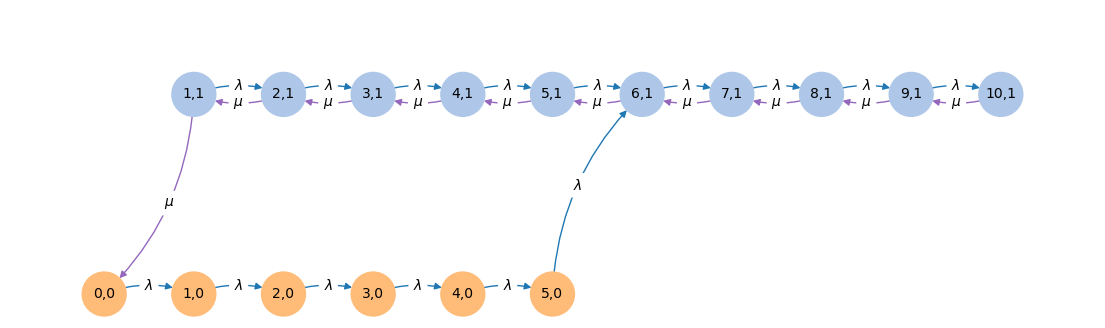

In [2]:
pos = {(x,y):(x,y) for (x,y) in G.states()}
G.drawTransitionGraph(pos, bended=True, label_pos=0.5, figsize=(14,4));

## Computation of System Characteristics
This function computes two key performance metrics for the N-policy video buffering system. The stalling ratio estimates the proportion of time the player is stalled, while the stall frequency approximates how often playback stalls occur, based on the rate of emptying the buffer right after playback starts.

In [3]:
# compute system characteristics based on steady state probs
def getSystemCharacteristicsSimple(G):    
    stalling_ratio = np.sum([ G.prob( (x,0)) for x in range(G.N)])
    stall_frequency = G.mu*G.prob((1,1))
    res = {"stall_ratio": stalling_ratio, "stall_frequency":stall_frequency }    
    return res

probs = G.calcSteadyStateProbs() # this is required to compute the steady state probabilities
res = getSystemCharacteristicsSimple(G)
for k in res:
    print(f"{k} = {res[k]:.4f}")

stall_ratio = 0.2894
stall_frequency = 0.0579


## Steady-State Probabilities
This plot visualizes the **steady-state probabilities** for each state in the 2D state space of the video player model. Each bar is colored according to the node's assigned category (e.g., playing or stalling), providing an intuitive view of system behavior under the N-policy.

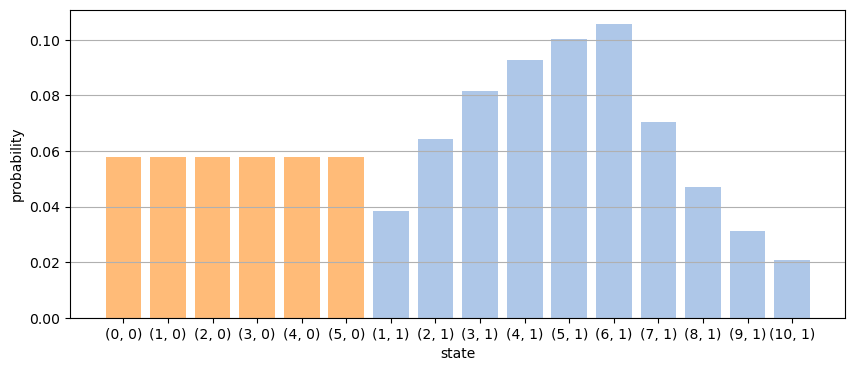

In [4]:
plt.figure(clear=True, figsize=(10,4))
x = np.arange(len(G))
y = [G.prob(s) for s in G]
cols = [G.nodes[s]["color"] for s in G]

plt.bar(x,y, color=cols, label='numerical')
plt.xticks(x, labels=G.states())
plt.xlabel('state')
plt.ylabel('probability')
plt.grid(axis='y', which='major')
plt.show();

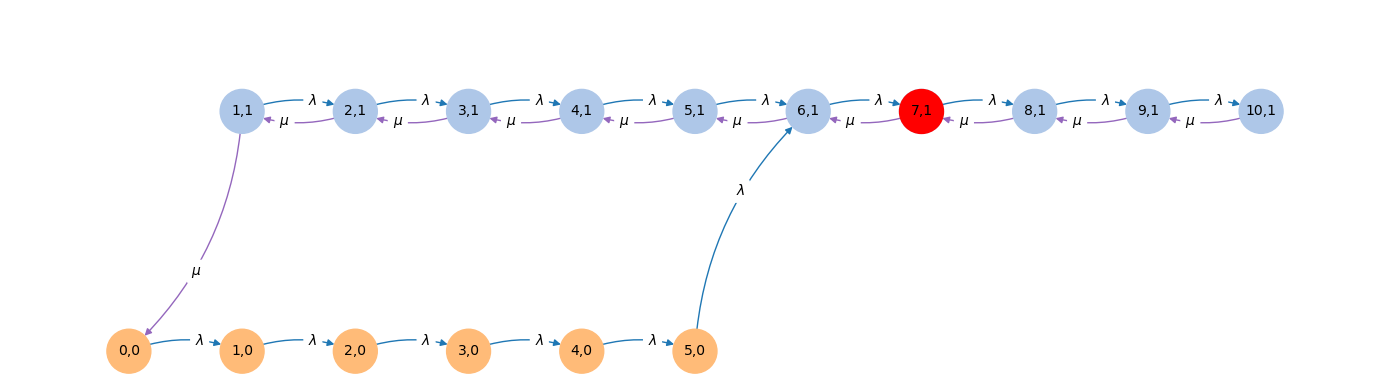

In [6]:
#%% Simulate and animate in Graph
states, times = G.simulateMarkovModel(startNode=(0,0), numEvents=200)
G.animateSimulation(expectedTimePerState=0.2, inNotebook=True, states=states, times=times, pos=pos, bended=True,figsize=(14,4));